<a href="https://colab.research.google.com/github/Sayana-mc/Drought-Impact-Detection-in-Croplands/blob/main/cv_project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import shutil # For moving files

# --- Configuration ---
# Define image parameters for consistency
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 2 # Assuming binary classification: 'drought' and 'non_drought'
EPOCHS = 15 # Number of training epochs, you can adjust this

# --- 1. Download Datasets ---
print("Attempting to download datasets from KaggleHub...")

# Dataset for Drought Images
drought_dataset_name = "kabeer2004/drought-images"
try:
    drought_path = kagglehub.dataset_download(drought_dataset_name)
    print(f"Drought dataset downloaded to: {drought_path}")
except Exception as e:
    print(f"Error downloading drought dataset '{drought_dataset_name}': {e}")
    print("Please ensure you have Kaggle API credentials configured correctly (kaggle.json).")
    exit("Exiting due to drought dataset download failure.")

# Dataset for Non-Drought (Healthy) Images
# Using 'muratkokludataset/rice-image-dataset' as a general source for healthy crop images.
# We will focus on one of its 'healthy' categories, e.g., 'Basmati'.
# You might need to adjust this if you find a more specific 'non-drought' crop dataset.
non_drought_dataset_name = "muratkokludataset/rice-image-dataset"
try:
    non_drought_path = kagglehub.dataset_download(non_drought_dataset_name)
    print(f"Non-drought dataset downloaded to: {non_drought_path}")
except Exception as e:
    print(f"Error downloading non-drought dataset '{non_drought_dataset_name}': {e}")
    print("Please ensure you have Kaggle API credentials configured correctly (kaggle.json).")
    exit("Exiting due to non-drought dataset download failure.")


# --- 2. Prepare Data Directory Structure in a Writable Location ---
# The previous error "Read-only file system" indicates that /kaggle/input is not writable.
# We need to copy the dataset to a writable location, e.g., /kaggle/working/
# and then organize it there.

writable_data_dir = '/kaggle/working/drought_project_data'
os.makedirs(writable_data_dir, exist_ok=True)
print(f"\nCreated writable data directory: {writable_data_dir}")

# Create the class subfolders in the writable directory
drought_folder = os.path.join(writable_data_dir, 'drought')
non_drought_folder = os.path.join(writable_data_dir, 'non_drought')

os.makedirs(drought_folder, exist_ok=True)
os.makedirs(non_drought_folder, exist_ok=True)
print(f"Created class subfolders: {drought_folder} and {non_drought_folder}")

# --- Copy Drought Images ---
source_drought_dir = os.path.join(drought_path, 'drought') # Assuming 'drought' subfolder
if not os.path.exists(source_drought_dir):
    print(f"Error: Expected 'drought' folder not found in downloaded path: {source_drought_dir}")
    exit("Exiting due to unexpected drought dataset structure.")

print(f"Copying images from '{source_drought_dir}' to '{drought_folder}'...")
drought_images_copied = 0
for filename in os.listdir(source_drought_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        shutil.copy(os.path.join(source_drought_dir, filename), drought_folder)
        drought_images_copied += 1
print(f"Finished copying {drought_images_copied} drought images.")

# --- Copy Non-Drought (Healthy) Images ---
# Dynamic discovery of class folders within rice-image-dataset
# The actual structure is usually rice-image-dataset/Rice_Image_Dataset/Basmati, Arborio, etc.
# Let's find the 'Rice_Image_Dataset' folder first.
found_rice_dataset_base = None
for item in os.listdir(non_drought_path):
    full_path = os.path.join(non_drought_path, item)
    if os.path.isdir(full_path) and "rice" in item.lower() and "image" in item.lower():
        found_rice_dataset_base = full_path
        break

if found_rice_dataset_base is None:
    print(f"Error: Could not find the main rice image dataset folder within {non_drought_path}")
    print("Please manually check the structure of 'muratkokludataset/rice-image-dataset'.")
    exit("Exiting due to unexpected non-drought dataset structure.")

# Now, list the class folders inside the discovered base
non_drought_class_folders = []
for item in os.listdir(found_rice_dataset_base):
    full_path = os.path.join(found_rice_dataset_base, item)
    if os.path.isdir(full_path):
        non_drought_class_folders.append(item)

if not non_drought_class_folders:
    print(f"Error: No class folders found within '{found_rice_dataset_base}' for non-drought images.")
    exit("Exiting due to no non-drought class folders.")

# Use the first found class folder as the source for non-drought images
# For instance, 'Basmati', 'Arborio', etc.
source_non_drought_subfolder = non_drought_class_folders[0]
source_non_drought_dir = os.path.join(found_rice_dataset_base, source_non_drought_subfolder)

print(f"Using '{source_non_drought_subfolder}' from '{non_drought_dataset_name}' as non-drought source.")
print(f"Copying images from '{source_non_drought_dir}' to '{non_drought_folder}'...")
non_drought_images_copied = 0
for filename in os.listdir(source_non_drought_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        shutil.copy(os.path.join(source_non_drought_dir, filename), non_drought_folder)
        non_drought_images_copied += 1
print(f"Finished copying {non_drought_images_copied} non-drought images.")

# Update base_data_dir to point to the writable location where data is now organized
base_data_dir = writable_data_dir


# --- 3. Data Loading and Preprocessing with Data Augmentation ---
print("\nSetting up data generators with augmentation...")
# Data augmentation for training to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Random rotations up to 20 degrees
    width_shift_range=0.2,      # Random horizontal shifts
    height_shift_range=0.2,     # Random vertical shifts
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flips
    fill_mode='nearest',        # Strategy for filling new pixels after transformations
    validation_split=0.2        # Use 20% of the data for validation
)

# Only rescaling for validation/test data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

try:
    train_generator = train_datagen.flow_from_directory(
        base_data_dir,           # Directory containing 'drought' and 'non_drought' subfolders
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',# For one-hot encoded labels (e.g., [1,0] for drought, [0,1] for non-drought)
        subset='training',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        base_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False # No need to shuffle validation data
    )
    print("Data generators created successfully.")
    print(f"Found {train_generator.n} training images belonging to {train_generator.num_classes} classes.")
    print(f"Found {validation_generator.n} validation images belonging to {validation_generator.num_classes} classes.")

    # Get class names from the generator, e.g., {'drought': 0, 'non_drought': 1}
    class_names = list(train_generator.class_indices.keys())
    print(f"Detected classes: {class_names}")

    if train_generator.num_classes < NUM_CLASSES:
        print("\nWARNING: ImageDataGenerator found fewer than the expected 2 classes. This is likely because one of your class folders (drought/non_drought) is empty or has no suitable images. Please check the contents of your writable data directory.")

except Exception as e:
    print(f"\nError creating data generators: {e}")
    print(f"This often means the directory '{base_data_dir}' does not contain correctly structured class subfolders (e.g., 'drought' and 'non_drought'), or they are empty.")
    print("Please check the actual content of the downloaded datasets and how they are copied/organized.")
    exit("Exiting due to data loading failure.")


# --- 4. Build the Deep Learning Model (CNN) ---
print("\nBuilding the Convolutional Neural Network (CNN) model...")
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the 3D output to 1D for the Dense layers
    Flatten(),

    # Dense layers for classification
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout layer to prevent overfitting (randomly sets 50% of inputs to 0)

    # Output layer: 2 neurons for 2 classes, 'softmax' for probability distribution
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
# Adam optimizer is a good default choice
# 'categorical_crossentropy' for multi-class classification with one-hot encoded labels
# 'accuracy' is the metric to monitor during training
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("CNN model built and compiled successfully.")

# --- 5. Train the Model ---
print("\nStarting model training...")
# Calculate steps per epoch to ensure the generator processes all images
# and doesn't get stuck in an infinite loop.
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
# Ensure STEP_SIZE_TRAIN is at least 1 to avoid division by zero or empty training
if STEP_SIZE_TRAIN == 0 and train_generator.n > 0:
    STEP_SIZE_TRAIN = 1
elif train_generator.n == 0:
    print("\nError: No training images found. Please ensure images are in your 'drought' and 'non_drought' folders.")
    exit("Exiting due to no training data.")


STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
if STEP_SIZE_VALID == 0 and validation_generator.n > 0:
    STEP_SIZE_VALID = 1
elif validation_generator.n == 0:
    print("\nError: No validation images found. Please ensure images are in your 'drought' and 'non_drought' folders.")
    # You might decide to continue training without validation if it's strictly necessary for a very small dataset
    # but it's not recommended for robust model training. For this example, we'll exit.
    exit("Exiting due to no validation data.")


history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS, # Use the defined number of epochs
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1 # Show progress during training
)
print("Model training completed.")

Attempting to download datasets from KaggleHub...


100%|██████████| 162M/162M [00:01<00:00, 138MB/s]

Extracting files...


Drought dataset downloaded to: /root/.cache/kagglehub/datasets/kabeer2004/drought-images/versions/1


100%|██████████| 219M/219M [00:01<00:00, 130MB/s]

Extracting files...


Non-drought dataset downloaded to: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1

Created writable data directory: /kaggle/working/drought_project_data
Created class subfolders: /kaggle/working/drought_project_data/drought and /kaggle/working/drought_project_data/non_drought
Copying images from '/root/.cache/kagglehub/datasets/kabeer2004/drought-images/versions/1/drought' to '/kaggle/working/drought_project_data/drought'...
Finished copying 280 drought images.
Using 'Basmati' from 'muratkokludataset/rice-image-dataset' as non-drought source.
Copying images from '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Basmati' to '/kaggle/working/drought_project_data/non_drought'...
Finished copying 15000 non-drought images.

Setting up data generators with augmentation...
Found 12224 images belonging to 2 classes.
Found 3056 images belonging to 2 classes.
Data generators created successfully.
Found 12224 train

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

CNN model built and compiled successfully.

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.9843 - loss: 0.1582 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 2/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.9999 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 3/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 4/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 5/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 6/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 7/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 8/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 1.0000 - loss: 0.0029 - val_accu


Evaluating model performance and plotting training history...


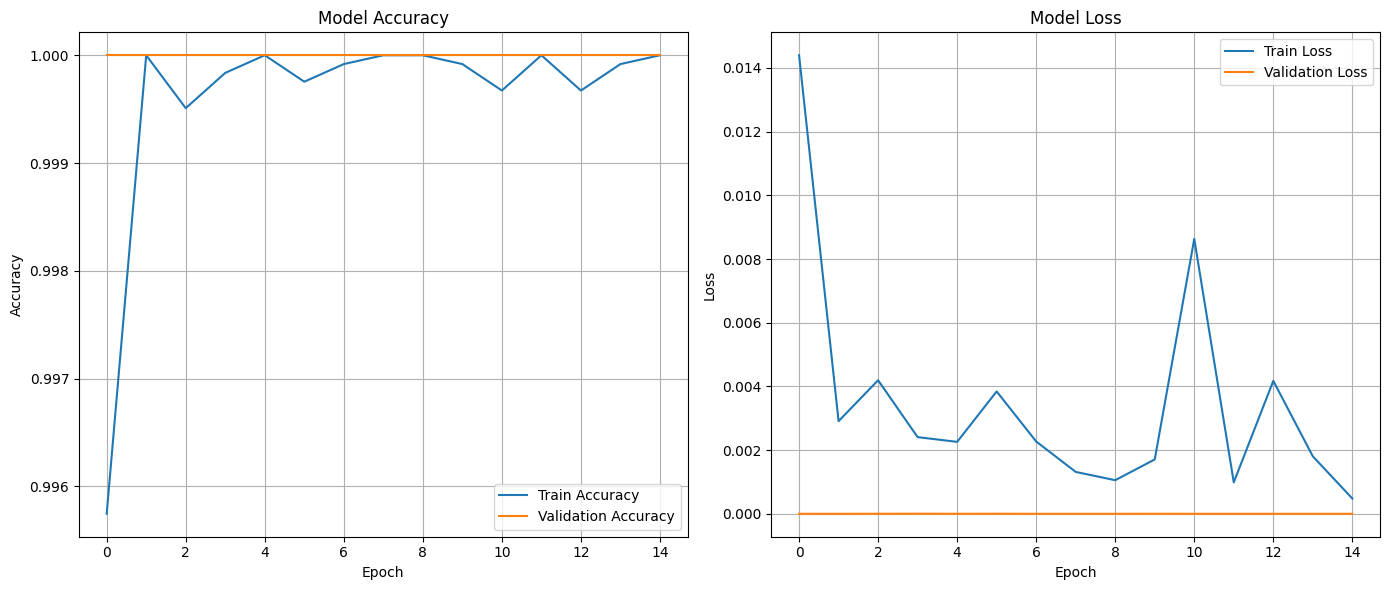


--- Project Summary ---
Drought detection model training complete.
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
Plots show model accuracy and loss over epochs.

--- Testing Model on a Single Image ---

Attempting to predict on: /content/drought1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Prediction for drought1.jpg:
Raw probabilities: [1.0000000e+00 3.2080594e-27]
Predicted Class: drought
Confidence: 1.00


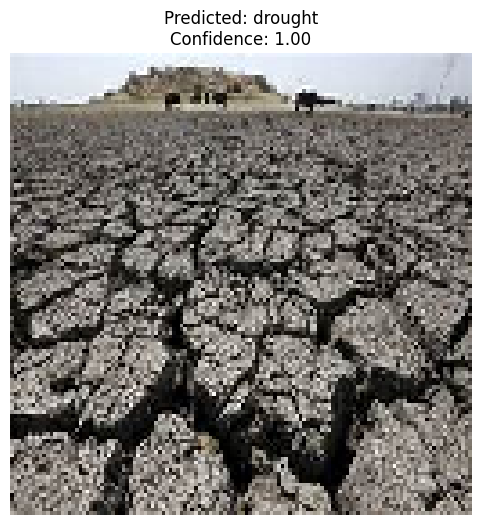


--- Testing Section Complete ---


In [ ]:
# --- 6. Evaluate and Visualize Performance ---
print("\nEvaluating model performance and plotting training history...")
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Project Summary ---")
print("Drought detection model training complete.")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print("Plots show model accuracy and loss over epochs.")

# Optional: Save the trained model for future use
# model.save('drought_impact_detection_model.h5')
# print("\nModel saved as 'drought_impact_detection_model.h5'")


# --- 7. Test the Model on a Single Image ---
print("\n--- Testing Model on a Single Image ---")

def predict_single_image(model, image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), class_names=None):
    """
    Loads an image, preprocesses it, and makes a prediction using the trained model.

    Args:
        model (tf.keras.Model): The trained Keras model.
        image_path (str): The file path to the image to predict.
        target_size (tuple): The target size (height, width) for resizing the image.
        class_names (list): A list of class names in the order they were used during training.
                            E.g., ['drought', 'non_drought'].
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    try:
        # Load the image and resize it
        img = load_img(image_path, target_size=target_size)
        # Convert the image to a NumPy array
        img_array = img_to_array(img)
        # Expand dimensions to create a batch of 1 image (required by model.predict)
        img_array = np.expand_dims(img_array, axis=0)
        # Rescale pixel values to [0, 1] as done during training
        img_array /= 255.0

        # Make prediction
        predictions = model.predict(img_array)
        # Get the class with the highest probability
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]

        print(f"\nPrediction for {os.path.basename(image_path)}:")
        print(f"Raw probabilities: {predictions[0]}")

        if class_names:
            predicted_class_name = class_names[predicted_class_index]
            print(f"Predicted Class: {predicted_class_name}")
        else:
            print(f"Predicted Class Index: {predicted_class_index}")

        print(f"Confidence: {confidence:.2f}")

        # Display the image with its prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name if class_names else predicted_class_index}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"An error occurred during prediction for {image_path}: {e}")

# --- Example Usage for Single Image Prediction ---
# Assuming the test image is directly in the root of the environment, like Colab or a local script
example_test_image_path = '/content/drought1.jpg' # The user-provided path

# Create a dummy test image folder in a writable directory for demonstration if needed,
# though the user provided a specific '/content/' path.
test_images_dir_for_example = '/kaggle/working/test_images_for_demonstration'
os.makedirs(test_images_dir_for_example, exist_ok=True)

# Check if the user-provided path exists before attempting prediction
if not os.path.exists(example_test_image_path):
    print(f"\n--- Action Required for Testing ---")
    print(f"The specified test image '{example_test_image_path}' was not found.")
    print(f"Please ensure '{example_test_image_path}' is accessible in your environment.")
    print(f"Alternatively, place a sample image in '{test_images_dir_for_example}' (e.g., 'my_drought_image.jpg')")
    print(f"and update 'example_test_image_path' to os.path.join(test_images_dir_for_example, 'my_drought_image.jpg').")
    print("Skipping single image prediction as the test image was not found.")
else:
    print(f"\nAttempting to predict on: {example_test_image_path}")
    predict_single_image(model, example_test_image_path, class_names=class_names)

print("\n--- Testing Section Complete ---")